# Satellites Tutorial

In this example we will explore the core functionality of BayesDB by using BayesDB to explore and analyze some real data. The data we will use is the Union of Concerned Scientists' Satellites data. The data is a catalogue of satellites. Each row of the data represents a satellite and each column is a feature of that satellite such as dry mass, orbit type, launch date, perigee, etc.

## Creating a table

We first open our Bayesian database that contains the Bayesian model of the satellites data. This database resides on disk in the form of a `.bdb` file. We first make a copy of this file to avoid modifying the original.

In [1]:
import bayeslite
import sys
import bayeslite.shell.pretty as pretty
import shutil
shutil.copy('satellites.bdb', 'satellites_copy.bdb')
satellites_bdb = bayeslite.bayesdb_open(pathname='satellites_copy.bdb')

This database contains a BayesDB table named `satellites`.

Now that we have the table, we can list the columns with their statistical types.

In [2]:
import bdbcontrib
bdbcontrib.bql_utils.get_column_info(satellites_bdb, 'satellites_cc')

[(1, u'Country_of_Operator', u'categorical'),
 (2, u'Operator_Owner', u'categorical'),
 (3, u'Users', u'categorical'),
 (4, u'Purpose', u'categorical'),
 (5, u'Class_of_Orbit', u'categorical'),
 (6, u'Type_of_Orbit', u'categorical'),
 (7, u'Perigee_km', u'numerical'),
 (8, u'Apogee_km', u'numerical'),
 (9, u'Eccentricity', u'numerical'),
 (10, u'Period_minutes', u'numerical'),
 (11, u'Launch_Mass_kg', u'numerical'),
 (12, u'Dry_Mass_kg', u'numerical'),
 (13, u'Power_watts', u'numerical'),
 (14, u'Date_of_Launch', u'numerical'),
 (15, u'Anticipated_Lifetime', u'numerical'),
 (16, u'Contractor', u'categorical'),
 (17, u'Country_of_Contractor', u'categorical'),
 (18, u'Launch_Site', u'categorical'),
 (19, u'Launch_Vehicle', u'categorical'),
 (20, u'Source_Used_for_Orbital_Data', u'categorical'),
 (21, u'longitude_radians_of_geo', u'cyclic'),
 (22, u'Inclination_radians', u'cyclic')]

We can count the number of rows in the table.

In [10]:
do_query(satellites_bdb, 'SELECT COUNT(*) FROM satellites;').as_df()

,"""COUNT""(*)"
0,1167


We can select data just as we would in SQL in BQL:

In [3]:
from bdbcontrib.facade import do_query
do_query(satellites_bdb,
        'SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites LIMIT 10;').as_df()

,Name,Dry_Mass_kg,Period_minutes,Class_of_Orbit
0,AAUSat-3,NaN,100.42,LEO
1,"ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1)",1730,1436.08,GEO
2,"ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A)",800,1436.13,GEO
3,"ABS-2i (MBSat, Mobile Broadcasting Satellite, ...",1700,1436.10,GEO
4,"ABS-7 (Koreasat 3, Mugungwha 3)",1800,1436.06,GEO
5,AcrimSat (Active Cavity Radiometer Irradiance ...,13,98.60,LEO
6,"Advanced Orion 2 (NROL 6, USA 139)",NaN,1436.14,GEO
7,"Advanced Orion 3 (NROL 19, USA 171)",NaN,1436.10,GEO
8,"Advanced Orion 4 (NRO L-26, USA 202)",NaN,1438.80,GEO
9,"Advanced Orion 5 (NRO L-32, USA 223)",NaN,NaN,GEO


We can also use visualization tools such as `histogram` to plot emperical frequencies. In the next example, the first argument `dry_mass_kg` is a `NUMERICAL` variable, and is plotted in different colors based on the `class_of_orbit`.

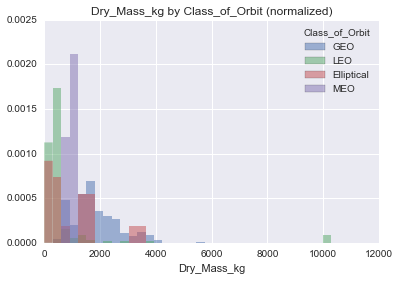

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
_ = bdbcontrib.histogram(satellites_bdb, 'SELECT dry_mass_kg, class_of_orbit FROM satellites', bins=35, normed=True)

Finally, we need to tell BayesDB which values to treat as missing, NULL. Different datasets use different markers for missing data, this dataset uses NaN. To convert all instances of NaN to SQL NULL, we use the `nullify` command, followed by the table, followed by the value to convert.

In [12]:
bdbcontrib.nullify(satellites_bdb, 'satellites', 'NaN')
do_query(satellites_bdb, 'SELECT name, dry_mass_kg FROM satellites LIMIT 10').as_df()

,Name,Dry_Mass_kg
0,AAUSat-3,NaN
1,"ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1)",1730
2,"ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A)",800
3,"ABS-2i (MBSat, Mobile Broadcasting Satellite, ...",1700
4,"ABS-7 (Koreasat 3, Mugungwha 3)",1800
5,AcrimSat (Active Cavity Radiometer Irradiance ...,13
6,"Advanced Orion 2 (NROL 6, USA 139)",NaN
7,"Advanced Orion 3 (NROL 19, USA 171)",NaN
8,"Advanced Orion 4 (NRO L-26, USA 202)",NaN
9,"Advanced Orion 5 (NRO L-32, USA 223)",NaN


Notice that `NaN` entires have been replaced with `None`, which is the
way Python represents SQL `NULL`.

In [13]:
# TODO pandas is pring None values as NaN, so the above text no longer makes sense
# TODO the original output looked like this:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('SELECT name, dry_mass_kg FROM satellites LIMIT 10'))

                                                   Name | Dry_Mass_kg
--------------------------------------------------------+------------
                                               AAUSat-3 |        None
          ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1) |        1730
               ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A) |         800
ABS-2i (MBSat, Mobile Broadcasting Satellite, Han Byul) |        1700
                        ABS-7 (Koreasat 3, Mugungwha 3) |        1800
 AcrimSat (Active Cavity Radiometer Irradiance Monitor) |          13
                     Advanced Orion 2 (NROL 6, USA 139) |        None
                    Advanced Orion 3 (NROL 19, USA 171) |        None
                   Advanced Orion 4 (NRO L-26, USA 202) |        None
                   Advanced Orion 5 (NRO L-32, USA 223) |        None


## Using Models of the Data

Before you can use BQL modelling for your data, you must use register a metamodel, such as the Crosscat metamodel with which the `.bdb` file was built.


In [14]:
import crosscat.LocalEngine
import bayeslite.crosscat
crosscat_engine = crosscat.LocalEngine.LocalEngine(seed=0)
crosscat_metamodel = bayeslite.crosscat.CrosscatMetamodel(crosscat_engine)
bayeslite.bayesdb_register_metamodel(satellites_bdb, crosscat_metamodel)

ValueError: Metamodel already registered: crosscat

We can now begin to ask BayesDB questions about the implications of the data.

## Inferring Values

Inferring is like imputing. `INFER` produces a summary value for a missing (`NULL`) entry. If we use the `EXPLICIT` keyword, we can re-infer present values.

First we will impute missing values of type_of_orbit. Let us see how many values are missing.

In [19]:
do_query(satellites_bdb, 'SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;').as_df()

,"""COUNT""(*)"
0,646


We will use the INFER EXPLICIT query to impute all missing values, and let BayesDB tell us the belief of its reported value. First we will pull out anticipated_lifetime, perigee_km, period_minutes, and class_of_orbit exactly as they appear in the table. Next we will use the special BQL expression PREDICT <col_name> CONFIDENCE <conf_name>, which will retrun two values: first, a prediction for <col_name> and second a confidence level for the predicted value.

In [20]:
# TODO this is a little slow, takes a minute or two
do_query(satellites_bdb, '''
CREATE TEMP TABLE inferred_orbit AS
INFER EXPLICIT
anticipated_lifetime, perigee_km, period_minutes, class_of_orbit,
PREDICT type_of_orbit AS inferred_orbit_type
CONFIDENCE inferred_orbit_type_conf
FROM satellites_cc
WHERE type_of_orbit IS NULL;
''')

ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



OperationalError: table "inferred_orbit" already exists

We can visualize the result both in tabular and graphical form.

In [21]:
do_query(satellites_bdb, 'SELECT * FROM inferred_orbit;').as_df()
# TODO: currently this is giving a different (wrong) result compared to:
# http://probcomp-4.csail.mit.edu/bayeslite/tutorials/satellites/satellites.html

,anticipated_lifetime,perigee_km,period_minutes,class_of_orbit,inferred_orbit_type,inferred_orbit_type_conf
0,1.0,770,100.42,LEO,Sun-Synchronous,0.64
1,15.0,35777,1436.08,GEO,NaN,0.98
2,10.0,35785,1436.13,GEO,NaN,0.97
3,12.0,35780,1436.10,GEO,NaN,0.96
4,15.0,35780,1436.06,GEO,NaN,0.98
5,NaN,35560,1436.14,GEO,NaN,0.96
6,NaN,35589,1436.10,GEO,NaN,0.98
7,NaN,35714,1438.80,GEO,NaN,0.99
8,NaN,35500,NaN,GEO,NaN,0.97
9,NaN,35771,23.94,GEO,NaN,0.37


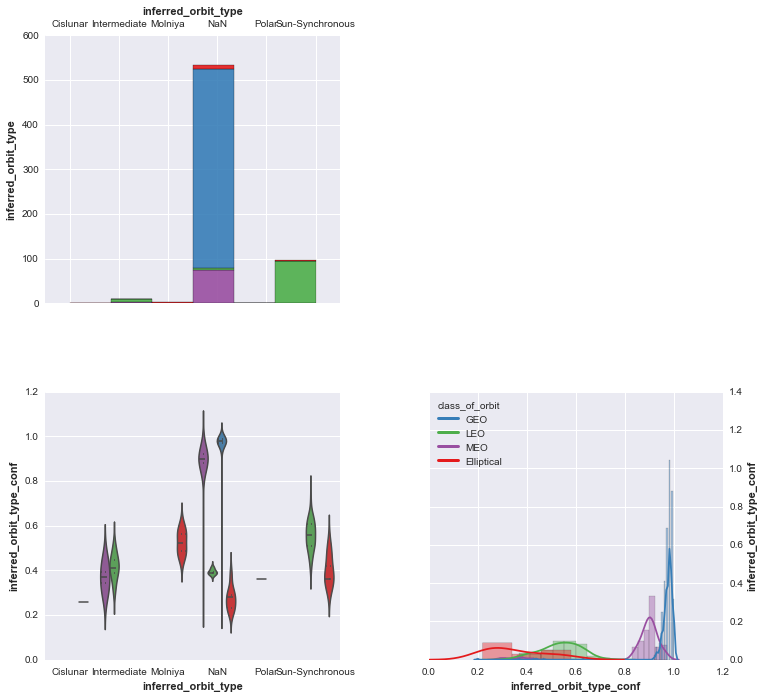

In [23]:
_ = bdbcontrib.pairplot(satellites_bdb,'''
    SELECT inferred_orbit_type, inferred_orbit_type_conf, class_of_orbit FROM inferred_orbit;
''', colorby='class_of_orbit')
# TODO wrong result

Now we shall impute missing values of dry_mass_kg. First, let us see how many values are missing.

In [24]:
do_query(satellites_bdb, 'SELECT COUNT(*) FROM satellites WHERE dry_mass_kg IS NULL;').as_df()

,"""COUNT""(*)"
0,677


Nearly half the values of dry mass are missing! We can visualize missing values in pairs of continuous columns using the `pairplot` visualization command with the `show-missing` option.

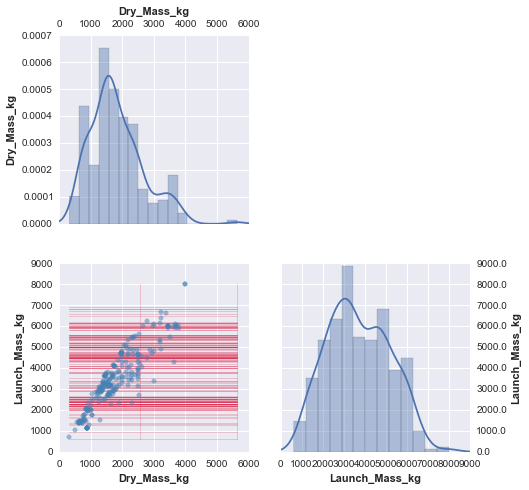

In [25]:
_ = bdbcontrib.pairplot(satellites_bdb, 'SELECT dry_mass_kg, launch_mass_kg FROM satellites WHERE class_of_orbit = GEO;', show_missing=True)

Missing values are represented as lines along their missing dimension. This way, we can see which values of the missing dimensions are more likely by observing where the lines intersect with the existing data points.

We will use the INFER command to impute missing values for geosynchronous satellites.

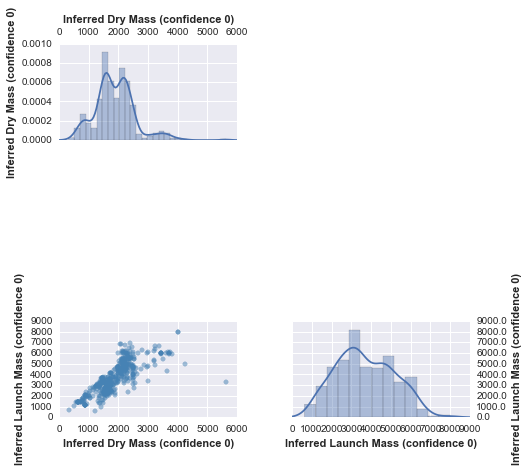

In [28]:
# TODO takes a minute or two
# TODO ugly plot layout
_ = bdbcontrib.pairplot(satellites_bdb, '''
INFER dry_mass_kg AS "Inferred Dry Mass (confidence 0)", 
    launch_mass_kg AS "Inferred Launch Mass (confidence 0)"
    WITH CONFIDENCE 0
    FROM satellites_cc
    WHERE class_of_orbit = GEO;
''', show_missing=True)

No more missing values. Notice the WITH CONFIDENCE clause. This tells BayesDB to impute entries only if it is confident to a certain degree. WITH CONFIDENCE 0 will then impute all values regardless; if we asked for confidence of 0.6 fewer entries (or perhaps none at all) would be filled in.

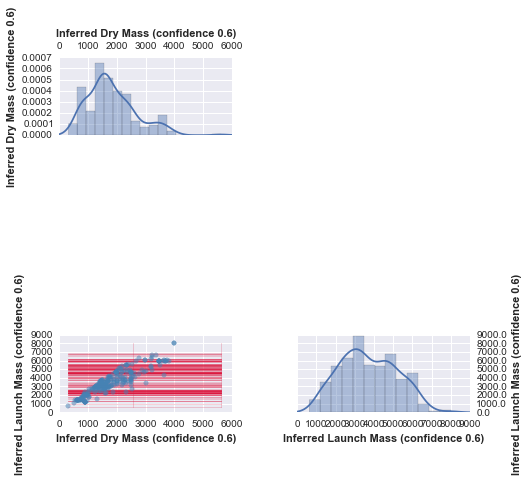

In [29]:
# TODO a little slow, takes a minute or two
# TODO ugly plot layout
_ = bdbcontrib.pairplot(satellites_bdb, '''
INFER dry_mass_kg AS "Inferred Dry Mass (confidence 0.6)",
    launch_mass_kg AS "Inferred Launch Mass (confidence 0.6)"
    WITH CONFIDENCE 0.6 
    FROM satellites_cc
    WHERE class_of_orbit = GEO;'
''', show_missing=True)

Notice that the number of red lines is exactly the same as before. This is because BayesDB does not have enough confidence (0.6) to fill in any missing values for dry_mass_kg.

BayesDB's notion of CONFIDENCE is unlike confidence in standard statistics. Whereas in standard statistics 'confidence' is typically paired with the word 'interval' to describe some region of probability mass, CONFIDENCE in BayesDB is a measure of inter-model agreement; that is, CONFIDENCE is the probability that among the models, there is a unimodal summary of the value we wish to impute given all other entries in that entry's row.

## Characterizing dependence between variables


Now that the analyses are finished, we can begin to ask BayesDB questions about the implications of the data. Often the first question we want to ask, especially if we are relatively clueless about the data, is which columns are most likely dependent on each other.

One of the most common statistical techniques for detecting dependence between variables is using correlation coefficients. BayesDB has the ability to compute observed correlation coefficients and their associated pvalues between all the pairs of columns, using the ESTIMATE PAIRWISE command; and because we do not want to look at at a very long table, we will visualize it in a heatmap using the `heatmap` command.

In [34]:
clustermap = bdbcontrib.heatmap(satellites_bdb,
    'ESTIMATE CORRELATION FROM PAIRWISE COLUMNS OF satellites_cc')
# TODO: this fails because the last two columns are cyclic type. in the original demo, the type was set to numerical.
# TODO: The bdb will need to be re-created and analyzed to support this query.

Traceback (most recent call last):
  File "build/bdist.macosx-10.9-x86_64/egg/bayeslite/bqlfn.py", line 55, in bayesdb_bql
    return fn(cookie, *args)
  File "build/bdist.macosx-10.9-x86_64/egg/bayeslite/bqlfn.py", line 85, in bql_column_correlation
    (st0, st1))
NotImplementedError: No correlation method for numerical/cyclic.



OperationalError: user-defined function raised exception

BayesDB has a more powerful notion of dependence called DEPENDENCE PROBABILITY, which is the degree of belief that two columns have some dependence. First let us see the probability that each column depdnds on perigee_km, and longitude_radians_of_geo.

In [38]:
do_query(satellites_bdb, '''
ESTIMATE *, DEPENDENCE PROBABILITY WITH perigee_km AS
"Probability of Dependence with Perigee"
FROM COLUMNS OF satellites_cc
ORDER BY "Probability of Dependence with Perigee" DESC LIMIT 10;
''').as_df()

,name,Probability of Dependence with Perigee
0,Class_of_Orbit,1.000000
1,Type_of_Orbit,1.000000
2,Perigee_km,1.000000
3,Apogee_km,1.000000
4,Source_Used_for_Orbital_Data,1.000000
5,Inclination_radians,1.000000
6,Purpose,0.984375
7,Period_minutes,0.984375
8,Users,0.968750
9,Launch_Site,0.968750


In [39]:
# TODO: giving different results from original demo output, probably due to use of cyclic datatypes here
do_query(satellites_bdb, '''
ESTIMATE *, DEPENDENCE PROBABILITY WITH longitude_radians_of_geo AS
"Probability of Dependence with Longitude Radians"
FROM COLUMNS OF satellites_cc
ORDER BY "Probability of Dependence with Longitude Radians" DESC LIMIT 10;
''').as_df()

,name,Probability of Dependence with Longitude Radians
0,longitude_radians_of_geo,1.000000
1,Launch_Mass_kg,0.781250
2,Dry_Mass_kg,0.765625
3,Power_watts,0.765625
4,Anticipated_Lifetime,0.703125
5,Date_of_Launch,0.687500
6,Operator_Owner,0.546875
7,Users,0.531250
8,Launch_Vehicle,0.531250
9,Purpose,0.515625


Let us now view all pairwise dependencies probabilities using the `heatmap` command. The entries along the diagnoal are 1, since each variable is dependent with itself. Notice that DEPENDENCE PROBABILITY determines a richer network of relationships than standard measures of correlation.



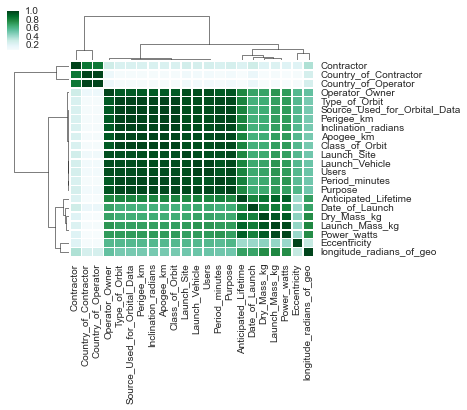

In [43]:
_ = bdbcontrib.heatmap(satellites_bdb, 'ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF satellites_cc;')

Each cell in the heatmap represents the dependence probability between a pair of columns. Darker cells represent higher dependence probability. The dendrogram is primarily for visualization, but clusters columns roughly into dependent groups. Note which groups of columns have the highest dependence probability. Do you notice any patterns? Many of the variables in this table are nearly deterministic, given the laws of physics. For example, we can determine a satellite's orbital period (the amount of time an orbit takes) form its perigee (lowest altitude of the orbit) and apogee (highest altitude of the orbit).

Which variables predict anticipated_lifetime --- which are the main predictors?

In [49]:
# TODO different results from original demo
do_query(satellites_bdb, '''
ESTIMATE *, DEPENDENCE PROBABILITY WITH anticipated_lifetime AS 
    "Probability of Dependence with Lifetime"
    FROM COLUMNS OF satellites_cc
    ORDER BY "Probability of Dependence with Lifetime" DESC LIMIT 10;
''').as_df()

,name,Probability of Dependence with Lifetime
0,Anticipated_Lifetime,1.000000
1,Power_watts,0.921875
2,Launch_Mass_kg,0.906250
3,Dry_Mass_kg,0.859375
4,Period_minutes,0.812500
5,Users,0.796875
6,Class_of_Orbit,0.796875
7,Type_of_Orbit,0.796875
8,Perigee_km,0.796875
9,Apogee_km,0.796875


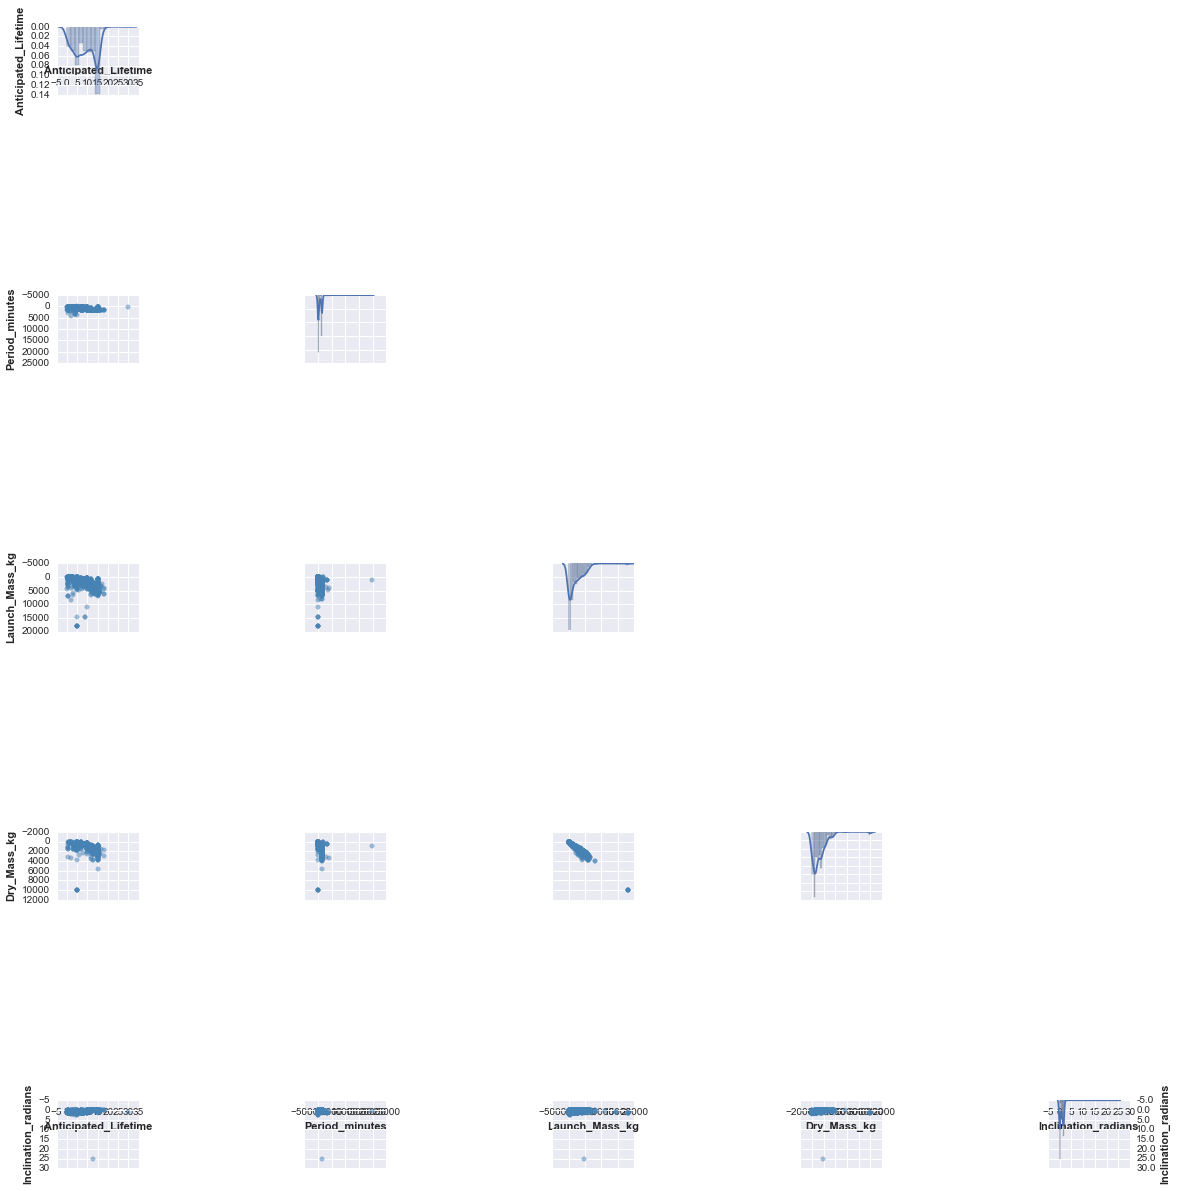

In [50]:
# TODO: poor plot layout
_ = bdbcontrib.pairplot(satellites_bdb, '''
SELECT anticipated_lifetime, period_minutes, launch_mass_kg, dry_mass_kg, inclination_radians FROM satellites;
''')

Let us look at the dependencies for other variables such as `purpose`.

In [53]:
# TODO fix results
do_query(satellites_bdb, '''
ESTIMATE *, DEPENDENCE PROBABILITY WITH purpose AS
    "Probability of Dependence with Purpose"
    FROM COLUMNS OF satellites_cc
    ORDER BY "Probability of Dependence with Purpose" DESC LIMIT 10;
''').as_df()

ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



OperationalError: user-defined function raised exception

## Identify satellites with unlikely lifetimes

We can use BayesDB to identify anomalous values in our table. An anomaly
is different from an outlier. An anomalous value is an observed value that
has a low probability under the inferred model; and outlier is defined
simply as having an extreme value. We can visualize this idea by creating
a scatter plot of data and their predictive probability functions
(`PREDICTIVE PROBABILITY`). We use the `ESTIMATE` keyword rather than
`SELECT` because we are asking questions of the generator. We also
specify that we only want the probabilities of non-null values using a
`WHERE` clause (the predictive probability of `NULL` is `NULL`).

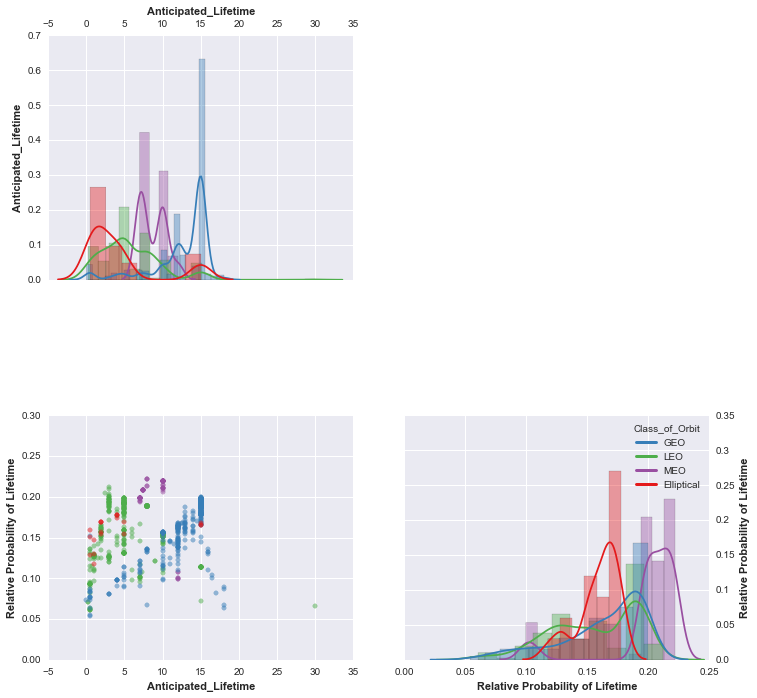

In [54]:
_ = bdbcontrib.pairplot(satellites_bdb, '''
ESTIMATE anticipated_lifetime,
PREDICTIVE PROBABILITY OF anticipated_lifetime AS "Relative Probability of Lifetime",
class_of_orbit
FROM satellites_cc
WHERE anticipated_lifetime IS NOT NULL;
''', colorby='class_of_orbit')

Note that there are plenty of non-extreme values that have low probabilities.
Let us get a list of the 10 most anomalous satellites by sorting by
`relative probability of lifetime` in ascending (`ASC`) order.

In [ ]:
do_query(satellites_bdb, '''
CREATE TEMP TABLE unlikely_lifetimes AS ESTIMATE name, anticipated_lifetime,
PREDICTIVE PROBABILITY OF anticipated_lifetime 
AS "Relative Probability of Lifetime"
FROM satellites_cc;
''').as_df()

In [ ]:
do_query(satellites_bdb, '''
SELECT * FROM unlikely_lifetimes
WHERE Anticipated_Lifetime IS NOT NULL 
ORDER BY "Relative Probability of Lifetime" ASC LIMIT 10;
''').as_df()

There are other values in the table with unlikely anticipated lifetimes, although
it is not entirely clear why BayesDB has identified them as such. To determine
why `Sicral 1A`, for instance, has a low probability lifetime, let us query
the satellites which BayesDB believes are similar to `Sicral 1A` using the
`SIMILARITY TO` query.

In [ ]:
do_query(satellites_bdb, '''
CREATE TEMP TABLE similiarity_to_sicral1a AS
ESTIMATE name, anticipated_lifetime,
SIMILARITY TO (name = 'Sicral 1A') AS sim_to_sicral
FROM satellites_cc;
''').as_df()

In [ ]:
do_query(satellites_bdb, '''
SELECT * FROM similiarity_to_sicral1a 
ORDER BY sim_to_sicral DESC LIMIT 10;
''').as_df()

All the satellites that BayesDB believes are similar to `Sicral 1A` have lifetimes
between 5 to 12 years, except for its sister satellite `Sicral 1B` which is
also an anomaly. Furthe research on these two satellites indicates that their
actual anticipated lifetime is 10 years; the database entry is an error.


Recall earlier that we mentioned that some of the relations are governed by
the laws of physics and are thus nearly deterministic? We can use this
determinism coupled with our notion of anomalousness to search the table for
data-entry errors. A geosynchronous orbit should take 24 hours
(1440 minutes). Let us display the anomalous values for satellites in
geosynchronous orbit.

In [ ]:
do_query(satellites_bdb, '''
CREATE TEMP TABLE unlikely_periods AS ESTIMATE name, class_of_orbit, period_minutes,
PREDICTIVE PROBABILITY OF period_minutes AS "Relative Probability of Period"
FROM satellites_cc;
''').as_df()

In [ ]:
do_query(satellites_bdb, '''
SELECT * FROM unlikely_periods
WHERE class_of_orbit IS GEO AND period_minutes IS NOT NULL
ORDER BY "Relative Probability of Period" ASC LIMIT 10;
''').as_df()

We see a couple of oddities. There are satellites with 24-minute periods. It
appears that these entries are in hours rather than minutes. There are other
entries that have too-short periods, which appear to be decimal errors.


**NOTE:** We have reported these errors to the database maintainers.


## Simulating entries

Suppose that we saw a satellite in geosynchrous orbit with a mass of
500kg; who launched it, and what is its purpose? We can ask BayesDB to simulate
this scenario for us. We will do this in two queries. In the first query, we
will create a temporary table (`TEMP TABLE`) consisting of simulated data using
the `SIMULATE` keyword (see Notes for more info about temporary tables); in the
second query, we will concatenate and organize the data for easy reading.

We `SIMULATE` the `Country` and `Purpose` variables, `GIVEN` that we have
observed the `Class_of_Orbit` and `Dry_Mass` (1000 simulations).
We specify the number of points to simulate using `LIMIT`.

In [ ]:
do_query(satellites_bdb, '''
CREATE TEMP TABLE satellite_purpose AS
SIMULATE country_of_operator, purpose FROM satellites_cc
GIVEN Class_of_orbit = GEO, Dry_mass_kg = 500 
LIMIT 1000;
''').as_df()

Note that everything after the `AS` is a perfectly valid query. `CREATE
TEMP TABLE satellite_purpose AS` saves the result of the query that follows it
into a table called `satellite_purpose` which we can refer to later. Temporary
tables are destroyed when the session is closed.

To determine which country-purpose combination is most probable
we will concatenate the values of the first two columns into a single
country-purpose column using the `||` operator, and then use SQLite's
`COUNT` function to calculate the frequencies. Let us look at the top 10
most frequent user-purpose combinations.

In [ ]:
do_query(satellites_bdb, '''
SELECT country_of_operator || "--" || purpose AS "Country-Purpose",
COUNT("Country-Purpose") AS frequency
FROM satellite_purpose
Group BY "Country-Purpose"
ORDER BY frequency DESC
LIMIT 10;
''').as_df()

We can visualize this data using the `.bar` command

In [ ]:
_ = bdbcontrib.barplot(satellites_bdb, '''
SELECT country_of_operator || "--" || purpose AS "Country-Purpose", 
COUNT("Country-Purpose") AS frequency
FROM satellite_purpose
GROUP BY "Country-Purpose"
ORDER BY frequency DESC
LIMIT 20;
''');